# NE 204 Lab 1 - Fitting Trapezoidal Filter Params

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.integrate as integrate
from scipy.optimize import curve_fit
import scipy.signal
from bokeh.io import show, output_file
from bokeh.plotting import figure
from bokeh.models import HoverTool
import time
import pandas as pd

# import tool repo
import sys

sys.path.append('/Users/kalie/courses/ne204/lab/kalieknecht_lab1')
from tools import find_activity, import_data, subtract_baseline
from filters import fit_tau, fit_taus, TrapezoidalFilter

# sys.path.append('/Users/kalie/courses/ne204/lab/lab_partners/ne204lib')
# from kit204lib.spectrum import Spectrum
# from kit204lib.filters import jordanov_filter, cooper_filter
# from kit204lib.analyze_waveform import plot_pulses, fit_tau
# from kit204lib.make_histogram import make_histogram
# from scipy.signal import find_peaks, peak_prominences

In [3]:
# function imports data, removes duplicate events, and converts to np.int16
# type conversion to np.int16 takes some time
f_name = '../data/calibration.h5'
calibration, calibration_events = import_data(f_name)

# f_name = 'data/cocs_calibration.h5'
# co_cs, co_cs_events = import_data(f_name)

# f_name = 'data/ba_calibration.h5'
# ba, ba_events = import_data(f_name)

In [4]:
calibration_bkg = subtract_baseline(calibration)

# fit tau

In [5]:
# first downsample data a reasonable amount
calibration_down = calibration_bkg[::100]
calibration_down.shape

(9131, 5000)

<IPython.core.display.Javascript object>


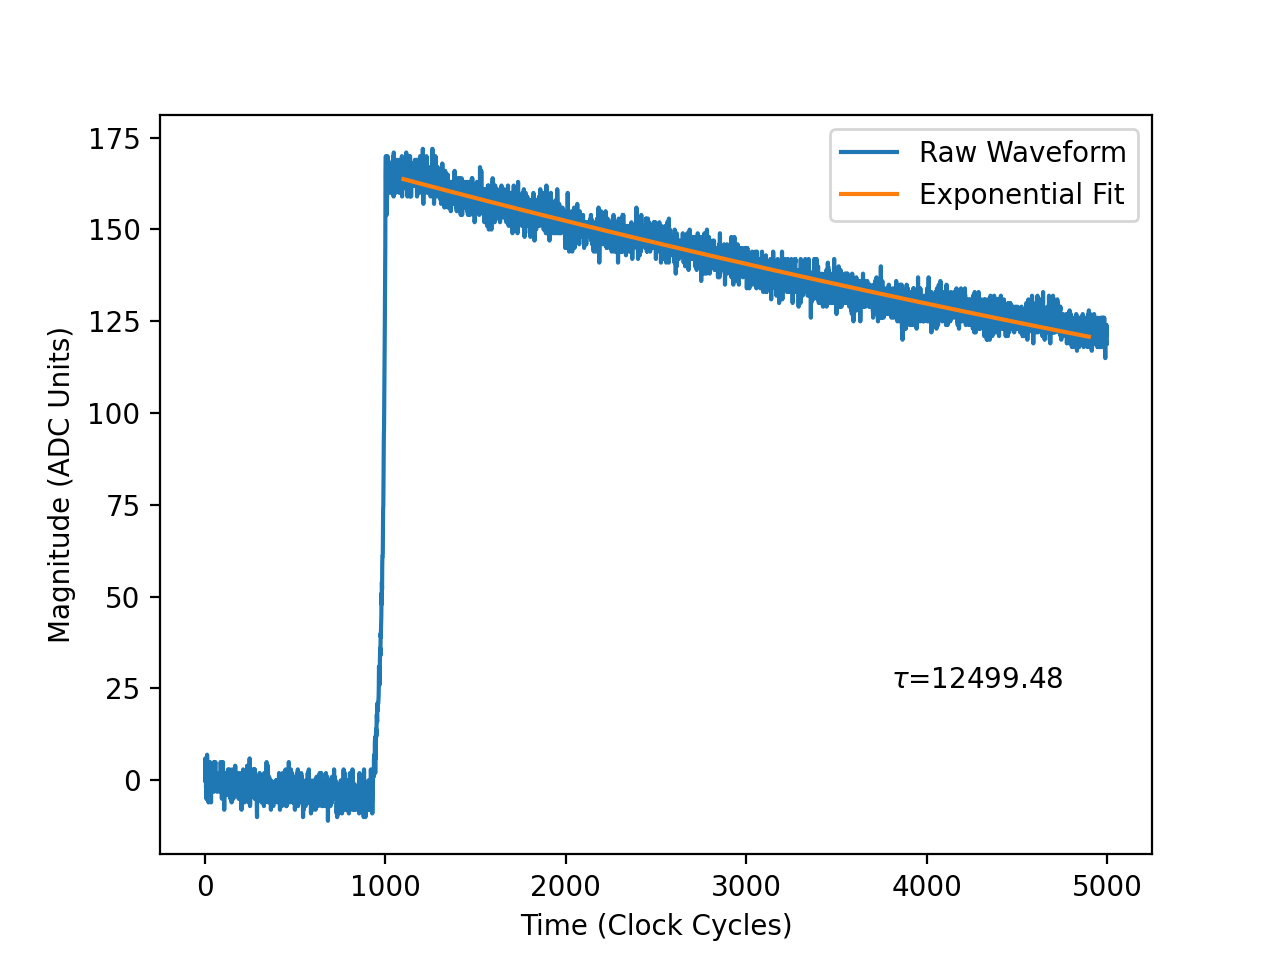

12499.475104450019

In [6]:
# example plot
fit_tau(calibration_bkg[0],show_plot=True,plot_save_name='../figs/tau_fit.png')

<IPython.core.display.Javascript object>


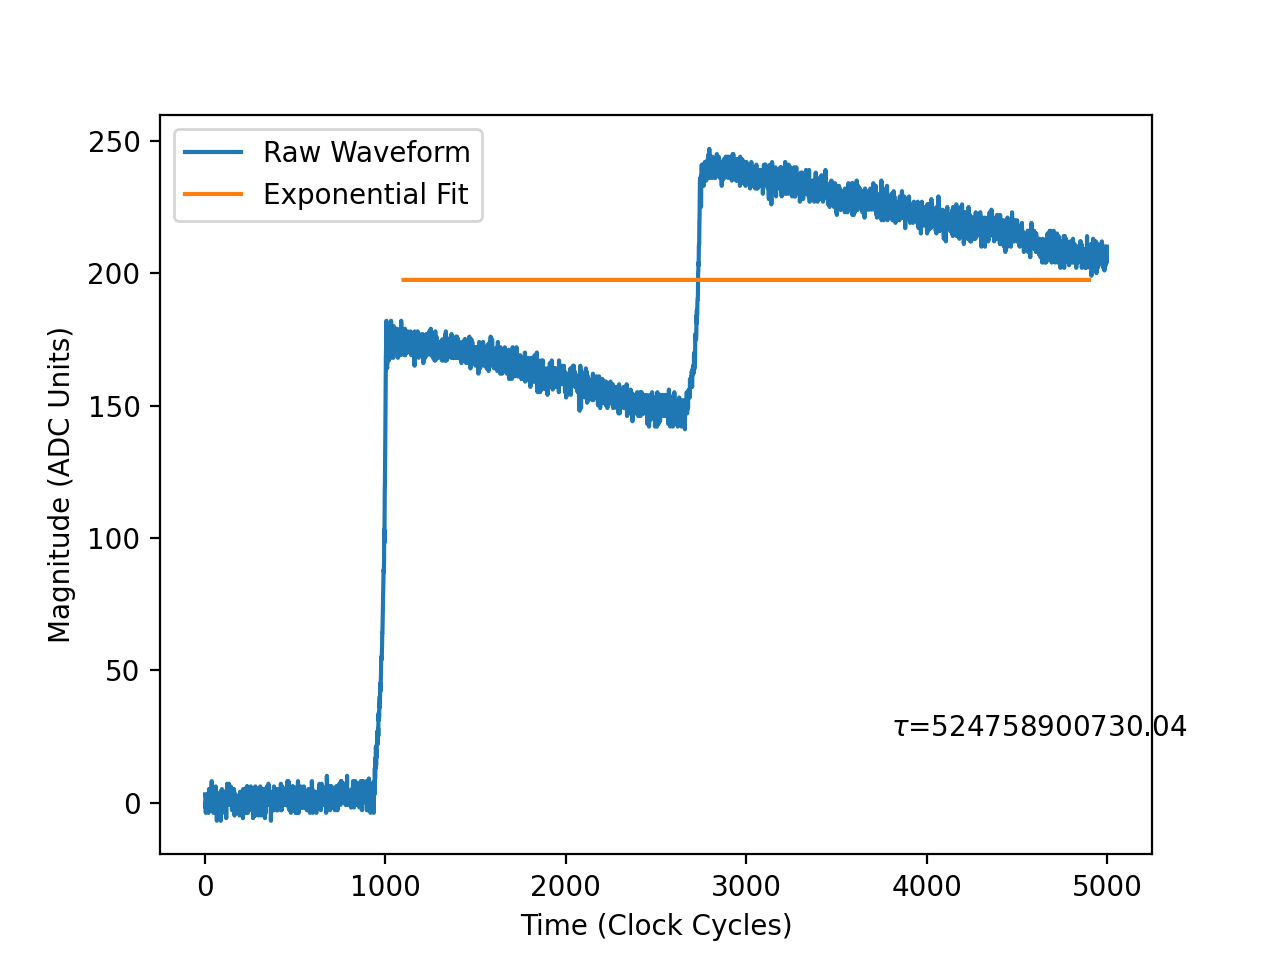

524758900730.0444

In [7]:
fit_tau(calibration_bkg[96],show_plot=True,plot_save_name='../figs/tau_fit_pileup.png')

In [8]:
tauvals = fit_taus(calibration_down)

mean and variance: 5641226553.945128 1.42101424495566e+21


In [9]:
# we can see we have a pretty large mean and standard deviation
# I expect tau to be around 12,000
# what is causing these high values?

# histograming shows we have some extraordinarily bad fits
np.histogram(tauvals,bins=10)

(array([8888,   44,   66,   53,   33,   22,   11,    8,    5,    1]),
 array([5.92771214e+02, 5.83708648e+10, 1.16741729e+11, 1.75112593e+11,
        2.33483457e+11, 2.91854322e+11, 3.50225186e+11, 4.08596050e+11,
        4.66966914e+11, 5.25337779e+11, 5.83708643e+11]))

In [10]:
# lets look at the bad taus
rough_tau_guess = 1e5 # we expect tau of 'good' pulses to be under this value
#mask *= tauvals < 0

high_tau_pulses = calibration_down[tauvals >= rough_tau_guess]
neg_tau_pulses = calibration_down[tauvals < 0 ]

<IPython.core.display.Javascript object>


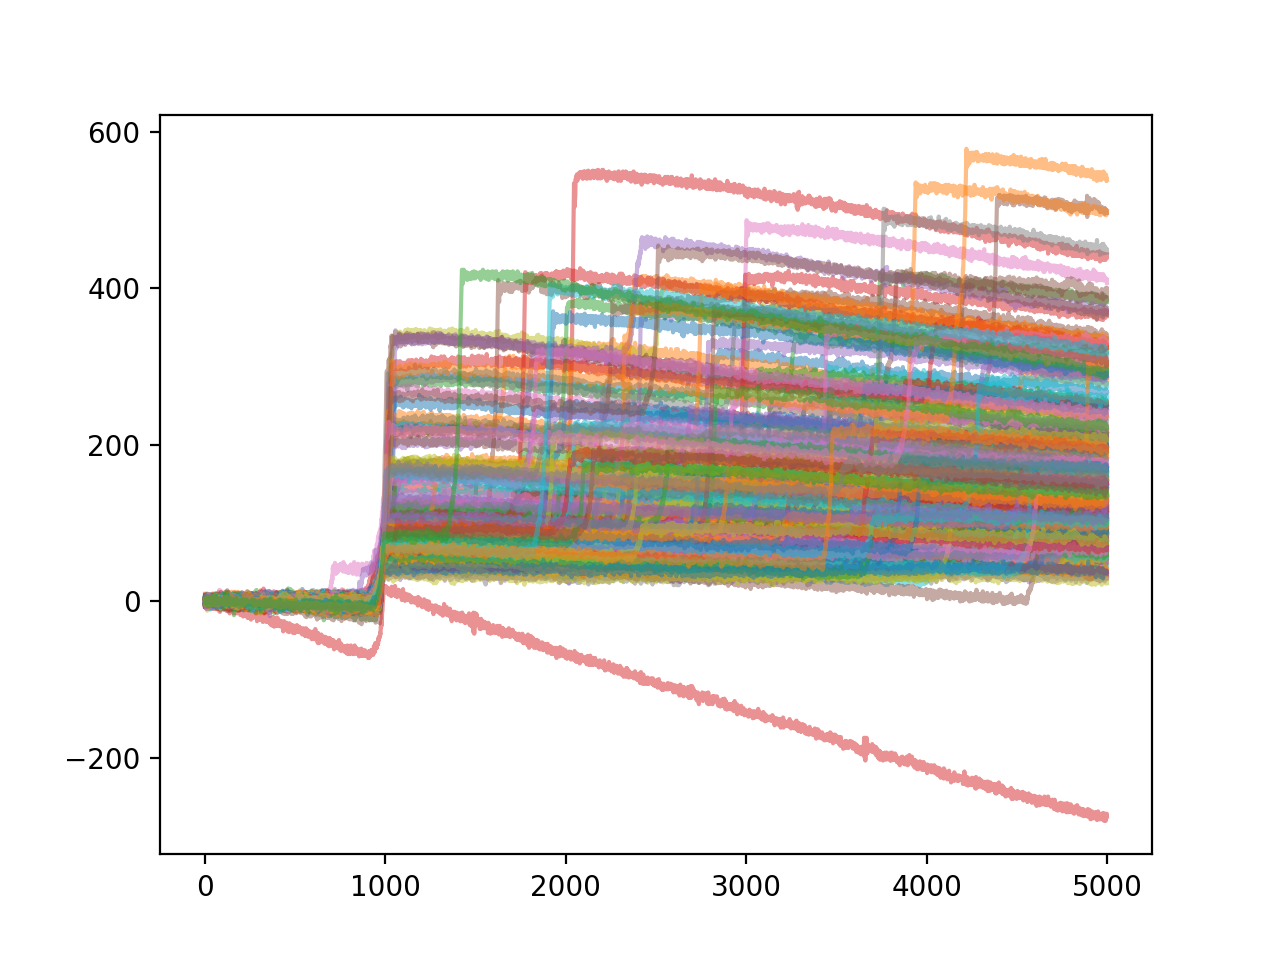

In [11]:
plt.figure()
for i in range(len(high_tau_pulses)):
    plt.plot(high_tau_pulses[i],alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


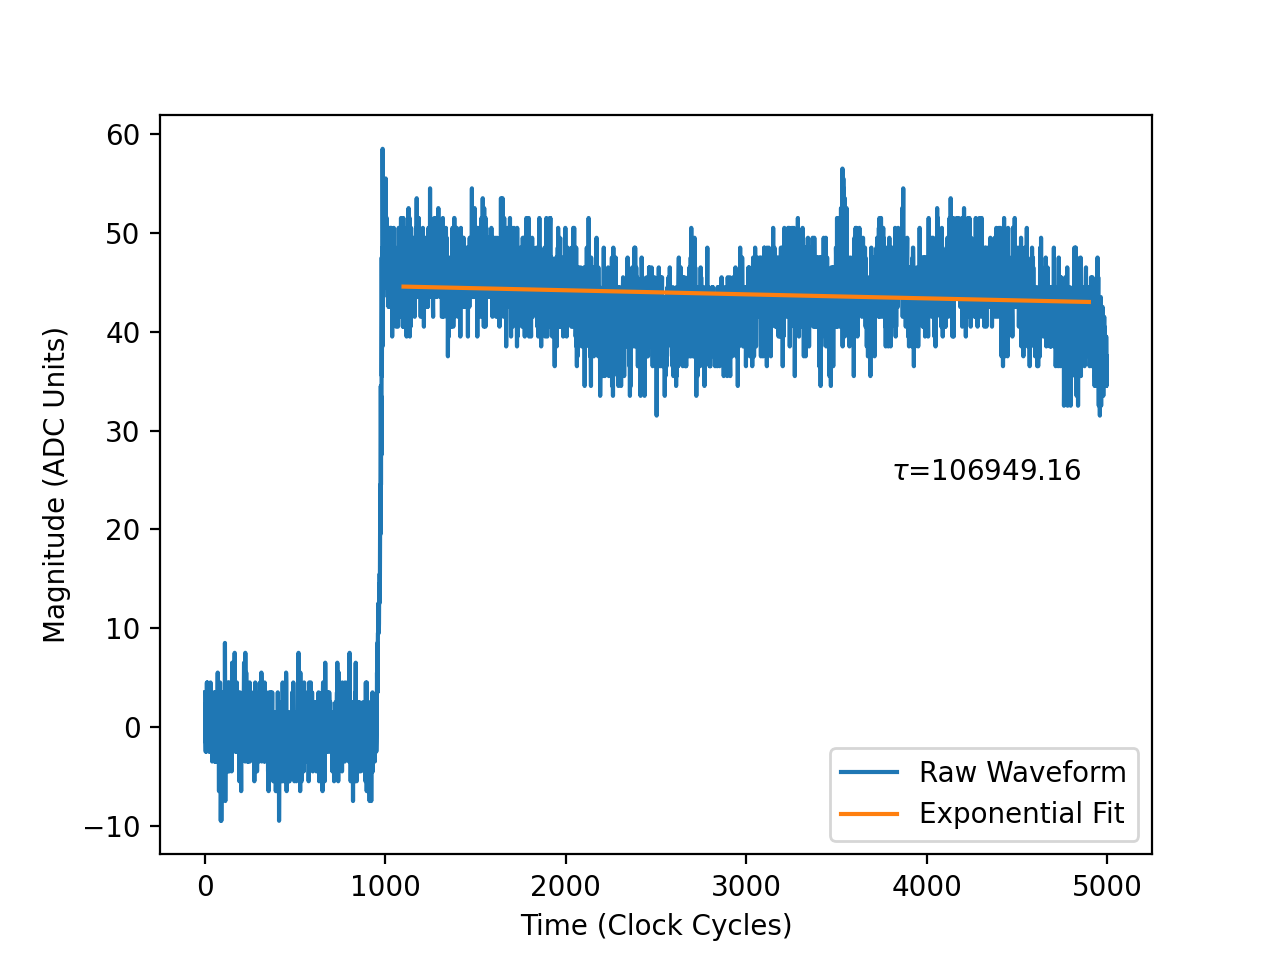

106949.16379555788

In [13]:
pulse_num = 6
fit_tau(high_tau_pulses[pulse_num],show_plot=True,plot_save_name='../figs/high_tau_pulse.png')

In [14]:
# we want to remove piled up pulses from our tau fit
# piled up pulses typically have large tau, or negative tau
mask = tauvals < rough_tau_guess
mask *= tauvals > 0
good_tau_pulses = calibration_down[mask]

tau_fixed = fit_taus(good_tau_pulses)

mean and variance: 11942.592814993079 29979470.071360987


In [15]:
np.histogram(tau_fixed,bins=50)

(array([  28,   87,  167,  450, 1186, 1976, 2324, 1168,  541,  309,  158,
         102,   85,   58,   47,   28,   17,   14,    6,   12,    6,    7,
           7,   13,    5,    6,    5,    1,    3,    7,    1,    1,    2,
           5,    0,    1,    2,    1,    2,    1,    0,    0,    2,    1,
           2,    0,    1,    2,    0,    1]),
 array([  592.77121376,  2300.55501187,  4008.33880998,  5716.12260809,
         7423.9064062 ,  9131.69020431, 10839.47400242, 12547.25780053,
        14255.04159864, 15962.82539675, 17670.60919486, 19378.39299297,
        21086.17679108, 22793.96058919, 24501.7443873 , 26209.52818541,
        27917.31198352, 29625.09578163, 31332.87957974, 33040.66337785,
        34748.44717596, 36456.23097407, 38164.01477218, 39871.79857029,
        41579.5823684 , 43287.36616651, 44995.14996462, 46702.93376273,
        48410.71756084, 50118.50135895, 51826.28515706, 53534.06895517,
        55241.85275328, 56949.63655139, 58657.4203495 , 60365.20414761,
        62

<IPython.core.display.Javascript object>


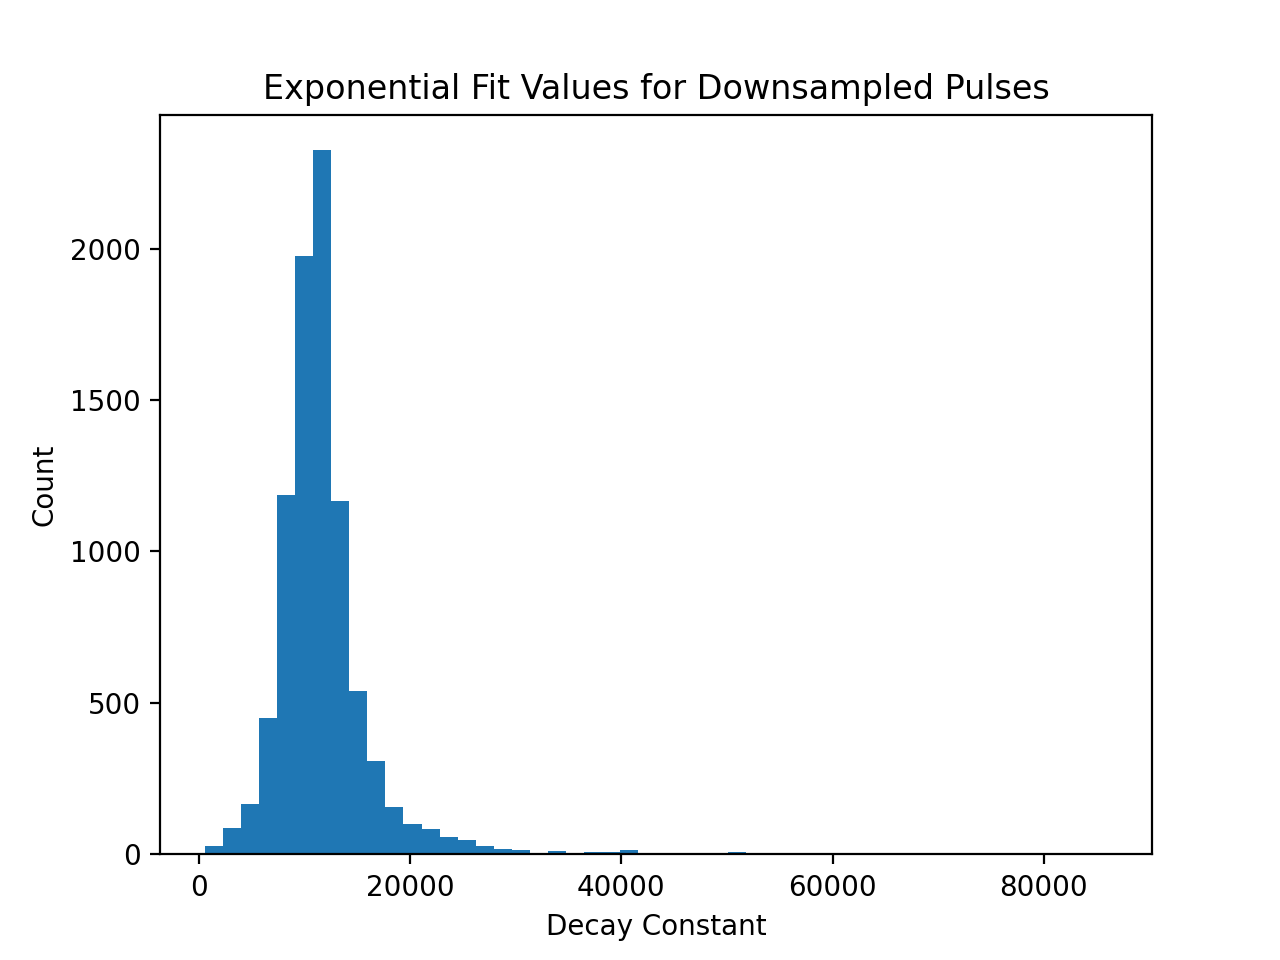

In [16]:
plt.figure()
plt.hist(tau_fixed,bins=50)
plt.xlabel('Decay Constant')
plt.ylabel('Count')
plt.title('Exponential Fit Values for Downsampled Pulses')
plt.show()

<IPython.core.display.Javascript object>


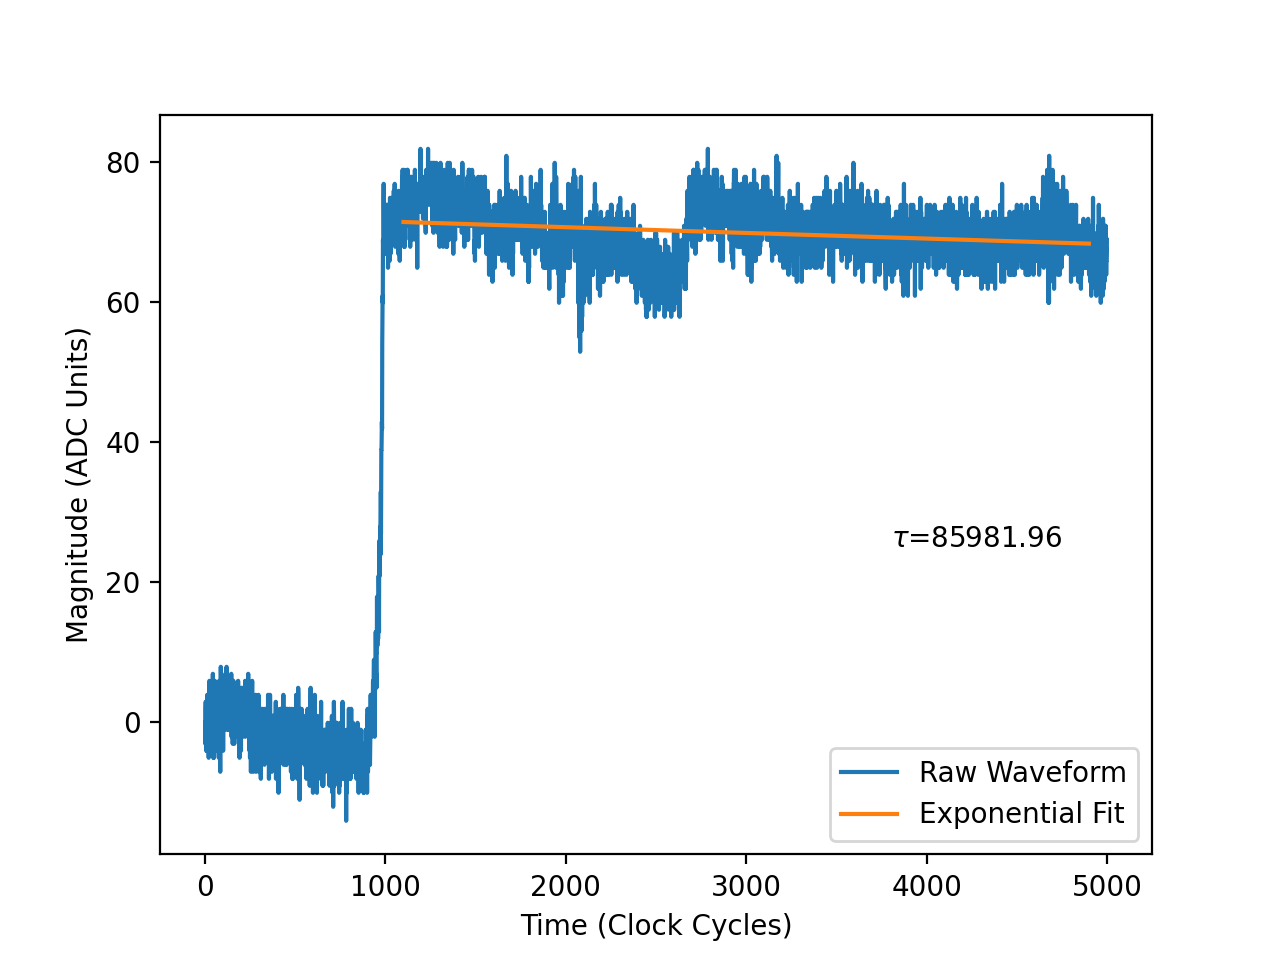

85981.96111925872

In [18]:
fit_tau(good_tau_pulses[np.argwhere(tau_fixed == tau_fixed.max())].flatten(),fit_length=3800,show_plot=True,plot_save_name='../figs/high_fit.png')

<IPython.core.display.Javascript object>


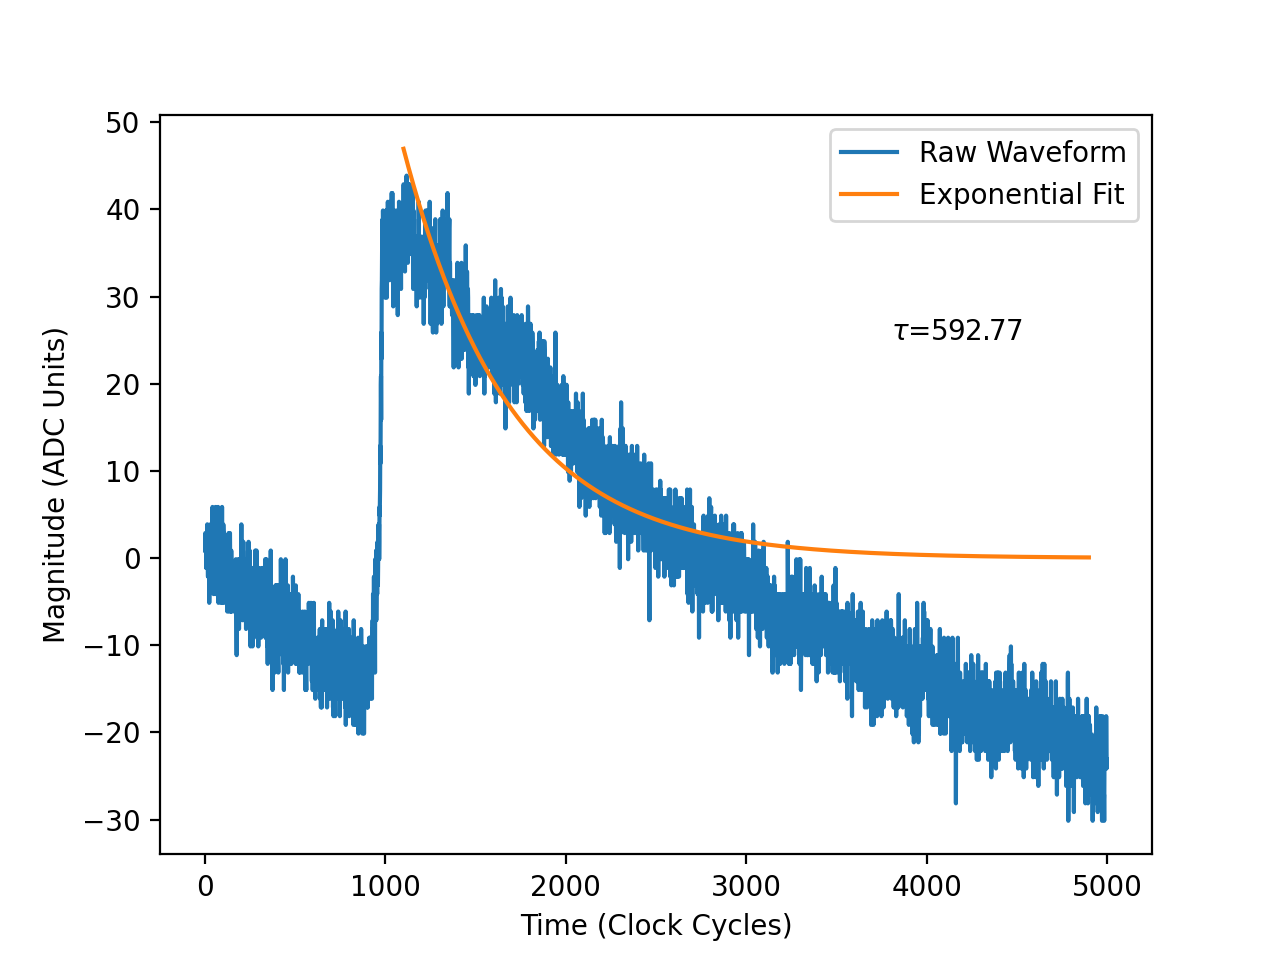

592.7712137588588

In [19]:
fit_tau(good_tau_pulses[np.argwhere(tau_fixed == tau_fixed.min())].flatten(),fit_length=3800,show_plot=True,plot_save_name='../figs/low_fit.png')

In [20]:
# cut more outliers out?
# we want to remove piled up pulses from our tau fit
# piled up pulses typically have large tau, or negative tau
mask = tau_fixed < 2e4 # less than 15000
mask *= tau_fixed > 1e3 # at least 1000
better_tau_pulses = good_tau_pulses[mask]

tau_final = fit_taus(better_tau_pulses)

np.histogram(tau_final)

mean and variance: 11099.251704766246 8502195.349170465


(array([  57,  123,  334, 1002, 1972, 2608, 1314,  567,  282,  170]),
 array([ 1095.18816943,  2985.60375814,  4876.01934685,  6766.43493556,
         8656.85052427, 10547.26611298, 12437.68170169, 14328.0972904 ,
        16218.51287911, 18108.92846782, 19999.34405653]))

<IPython.core.display.Javascript object>


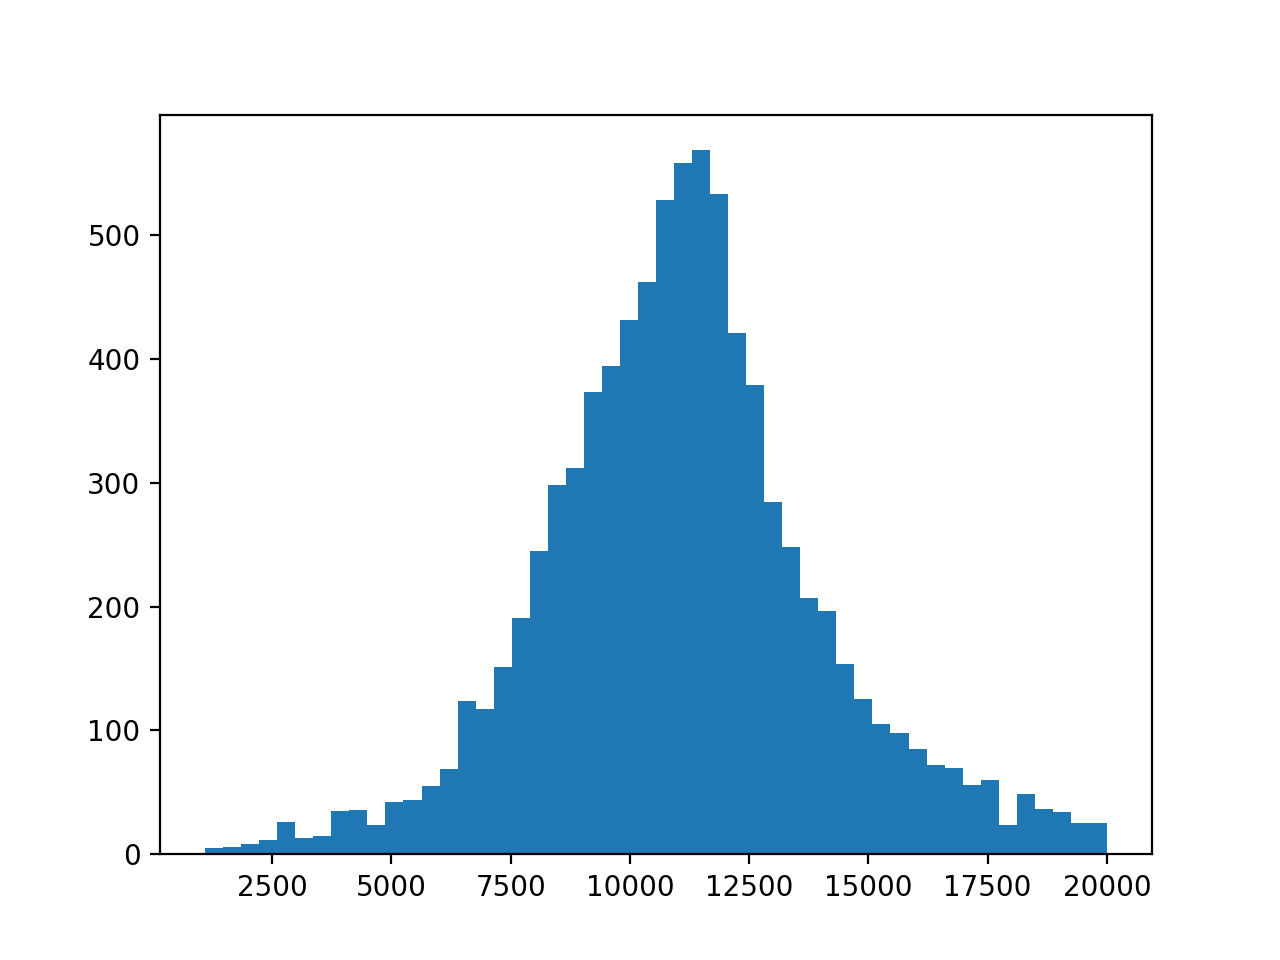

In [21]:
plt.figure()
plt.hist(tau_final,bins=50)
plt.show()

In [23]:
time_constant = tau_final.mean()
time_constant

11099.251704766246